In [1]:
# DELPHI simulations on LHC
## Tests on convergence criterion

#### DELPHI_original is DELPHI.py file from 24/05/2016 (commit 148784d0)
#### The resulting eigenvalues are saved in numpy .npy files

### 0.1) Import libraries

In [2]:
%matplotlib notebook

import os, sys
sys.path.append("/afs/cern.ch/user/n/nbiancac/ln_work/scratch0/IRIS/LHC_IW_model/Python-scripts")
sys.path.append("/afs/cern.ch/user/n/nbiancac/ln_work/scratch0/IRIS/HLLHC_IW_model/Python-scripts")
from __future__ import division
from Impedance import *
#from DELPHI_testing import *
#from DELPHI import *
from DELPHI_EVectors import *
from string import *
from LHC_param import *
#from SPS_param import SPS_param
import itertools

from  scipy.constants import c as clight
import scipy.special
from scipy.misc import factorial
import collections
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# First version: without exp(-j*l*phi)
#Construction of R(tau) as in N.Mounet, "DELPHI_expanded", slides 22 and 39

def R_computation_v2(EValue_number, EVectors, lmax, nmax, r, a, b, taub, clight=299792458):
    ''' Computes R(tau) as defined in as in N. Mounet, "DELPHI_expanded", slide 22
    It takes in input: 
    -EValue_number: eigenvalue number we are looking at
    -EVectors_converged: full eigenvectors table
    -lmax and nmax: max number of azimuthal and radial modes
    -tau: a range of values for tau
    '''

    #Rl is an interdemediate variable for the calculations, see N. Mounet, slide 39
    #Rl_table contains the Rl for all the l from lmax to -lmax-1
    Rl = np.zeros(len(r), dtype=complex)
    Rl_table = np.zeros((2*lmax+1,len(r)), dtype=complex)

    #Rsum contains the result of the addition of all Rl
    Rsum = np.zeros(len(r), dtype=complex)

    #First the computation of each Rl
    for l in range(lmax,-lmax-1,-1):

        for n in range(nmax+1):
            
            Rl += (EVectors[EValue_number,-(nmax+1)*l + (nmax+1)*lmax + n]) * scipy.special.eval_genlaguerre(n,abs(l),a*((r/clight)/taub)**2)

        Rl *= (r/(clight*taub))**(abs(l)) * np.exp(-b*((r/clight)/taub)**2)

        #Each Rl is stored then erased
        Rl_table[lmax-l,:] = Rl

        Rl = np.zeros(len(r),dtype=complex)

    
    #Then the computation of R(tau)
    for ii in range(0,len(Rl_table)):

        Rsum += Rl_table[ii]
       
    
    return Rsum, Rl_table

## 1) Retrieving LHC impedance

In [4]:
# machine parameters for HLLHC
machine2save='HLLHC'; 
beam='1';

from HLLHC_param import *

e,m0,c,E0=proton_param();

root_result='/afs/cern.ch/user/n/nbiancac/ln_work/scratch0/DELPHI_results/LHC/RunII/'
scenario='LHC_ft_6.5TeV_B1_2016'
machine=LHC(E0,E=6.5e12,scenario='Nominal LHC')

imp_mod=[]; wake_mod=[];
suffix='_Total_'+scenario+'.dat';
freq_mod,Z_mod=readZ(root_result+scenario+"/Zxdip"+suffix);
imp_mod.append(impedance_wake(a=1,b=0,c=0,d=0,plane='x',var=freq_mod,func=Z_mod));
freq_mod,Z_mod=readZ(root_result+scenario+"/Zydip"+suffix);
imp_mod.append(impedance_wake(a=0,b=1,c=0,d=0,plane='y',var=freq_mod,func=Z_mod));
freq_mod,Z_mod=readZ(root_result+scenario+"/Zlong"+suffix);
imp_mod.append(impedance_wake(a=0,b=0,c=0,d=0,plane='z',var=freq_mod,func=Z_mod));

In [5]:
# beam parameters
e,m0,c,E0=proton_param();

# scenario
scenario='LHC_ft_6.5TeV_B1_2016'
energy=6500.0e9

os.system("mkdir -p "+root_result);
   
# machine parameter    
machine_str,E,gamma,sigmaz,taub,R,Qx,Qxfrac,Qy,Qyfrac,Qs,eta,f0,omega0,omegas,dphase,Estr,V,h,M,en=LHC_param(E0,E=energy,scenario='Nominal LHC')

In [6]:
# longitudinal distribution
avbetax=machine.R/machine.Qx;avbetay=machine.R/machine.Qy; # average beta functions used
g,a,b=longdistribution_decomp(machine.taub,typelong="Gaussian");

## 2) Computation with eigenmodesDELPHI_converged, no damper


### 2.1) Parameters for eigenmodesDELPHI_converged

In [7]:
#DELPHI parameters

#Number of bunches, coupled bunch mode, particles per bunch
M = 1 # 2748, 3564
nx = 0
Nb = 1.2e11


# Qpscan=np.arange(-10, 12, 2)
omega0=machine.omega0
taub=machine.taub
Qxfrac=machine.Qxfrac
Qyfrac=machine.Qyfrac
gamma=machine.gamma
eta=machine.eta
f0=machine.f0
dphase=machine.dphase
Qx=machine.Qx
Qy=machine.Qy
omegas=machine.omegas

# Qpscan = np.arange(-15,15,2)
Qpscan = np.array([0])
omegaksiscan = Qpscan*omega0/eta

#Frequency downsampling
nevery = 1 

#Convergence criterion
crit = 5.e-2
abseps = 1.e-4



# Impedance and damper matrix coefficient computation
dmax=0.02
dnormfactor=compute_damper_matrix(0,0,0,M,0.0,omega0,Qxfrac,a,b,taub,g,flagdamperimp=0,d=None,freqd=None,abseps=abseps)
dnormfactor=2*np.pi*dnormfactor[0,0,0,0]

coefdamper, coefZ = computes_coef(f0,dmax,b,g[0],dnormfactor,taub,dphase,M,Nb,gamma,Qx,particle='proton');

#Tables used for eigenmodesDELPHI output
lmaxold = 1
nmaxold = 1

eigenvalues_converged = np.empty((len(Qpscan)), dtype = np.object_)
eigenvectors_converged = np.empty((len(Qpscan)), dtype = np.object_)

lmax = np.empty((len(Qpscan)), dtype = np.object_)
nmax = np.empty((len(Qpscan)), dtype = np.object_)

#matdamperold = np.zeros((2*lmaxold+1,nmaxold+1,2*lmaxold+1,nmaxold+1),dtype=complex)
#matZold = np.zeros((2*lmaxold+1,nmaxold+1,2*lmaxold+1,nmaxold+1),dtype=complex)

### 2.2) Computations

In [8]:
mainDir= '/afs/cern.ch/work/n/nbiancac/scratch0/IRIS/DELPHI/PYTHON_codes_and_scripts/Notebooks/'

comp='Zxdip'
aa,bb,cc,dd,plane,wakeflag=identify_component(comp)
# test_impedance_wake_comp(imp_mod, aa, bb, cc, dd, plane)
# Z_tot=imp_comp.func[:,0]+1j*imp_comp.func[:,1]
# freq_tot=imp_comp.var

for imp_comp in imp_mod:
    if test_impedance_wake_comp(imp_comp, aa, bb, cc, dd, plane):
        Z=np.hstack((imp_comp.func[:,0].reshape(-1,1),imp_comp.func[:,1].reshape(-1,1)))
        freq=imp_comp.var


mainDir='.'
DELPHI_results_dir='/Results/'
scenario ='LHC'
os.system("mkdir -p "+DELPHI_results_dir)

simulation_number=1

basename = DELPHI_results_dir+'/'+scenario+'_d'+float_to_str(dmax)+'_crit'+float_to_str(crit)+'_abseps'+float_to_str(abseps)+'_simulation'+str(simulation_number)

for iOmegaksi, omegaksi in enumerate(omegaksiscan):
    print Qpscan[iOmegaksi]
    eigenvalues_converged[iOmegaksi], eigenvectors_converged[iOmegaksi], lmax[iOmegaksi], nmax[iOmegaksi], _, _ = eigenmodesDELPHI_converged(nx,M,omegaksi,omega0,Qxfrac,a,b,taub,g,Z,freq,coefdamper,coefZ,omegas,flag_trapz=0,flagdamperimp=0,d=None,freqd=None,kmax=1,crit=crit,abseps=abseps,lmaxold=-1,nmaxold=-1,matdamperold=None,matZold=None,flageigenvect=True)
    
    

np.save(mainDir+basename+'_Qpscan', Qpscan)
np.save(mainDir+basename+'_EValues', eigenvalues_converged)
np.save(mainDir+basename+'_EVectors', eigenvectors_converged)
np.save(mainDir+basename+'_lmax', lmax)
np.save(mainDir+basename+'_nmax', nmax)

/home/nick/HDD/Work/Python-scripts/DELPHI/DELPHI_Python/DELPHI_EVectors.py:170: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (damperold==None) or ( ( (l>lmaxold)or(lprime>lmaxold) ) or ( (n>nmaxold)or(nprime>nmaxold) ) ):
/home/nick/HDD/Work/Python-scripts/DELPHI/DELPHI_Python/DELPHI_EVectors.py:80: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (couplold==None) or ( ( (l>lmaxold)or(lprime>lmaxold) ) or ( (n>nmaxold)or(nprime>nmaxold) ) ):


0


#### Loading the results from previous simulations

[0]


<IPython.core.display.Javascript object>


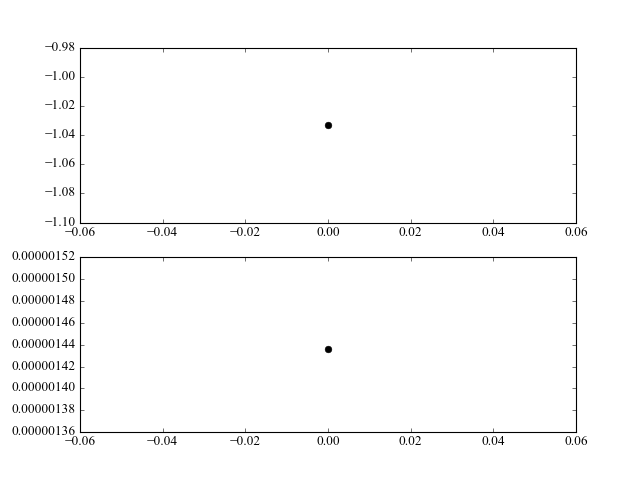

In [9]:
Qpscan=np.load(mainDir+basename+'_Qpscan.npy')
eigenvalues_converged=np.load(mainDir+basename+'_EValues.npy')
eigenvectors_converged=np.load(mainDir+basename+'_EVectors.npy')
lmax=np.load(mainDir+basename+'_lmax.npy')
nmax=np.load(mainDir+basename+'_nmax.npy')

print Qpscan
mum = []

for iQp, Qp in enumerate(Qpscan):
    mum.append(np.conj(eigenvalues_converged[iQp][0])/omega0)

mum=np.array(mum)
Qs=machine.Qs
plt.figure()
plt.subplot(2,1,1)
plt.plot(Qpscan,(mum.real)/Qs,'ok')
plt.subplot(2,1,2)
plt.plot(Qpscan,mum.imag,'ok')



0


<IPython.core.display.Javascript object>


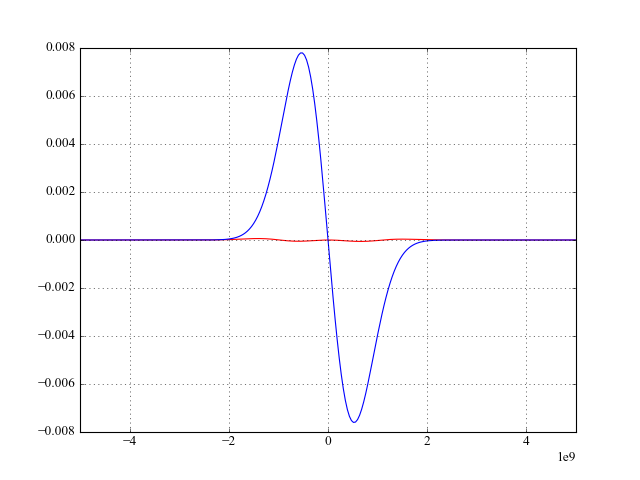

In [10]:
R = machine.R
Qpindex = np.where(Qpscan==0)[0][0]
Qpindex = 0
print Qpscan[Qpindex]

EValue_number=0

# the sampling
tau = np.linspace(0,100.0e-9,10000)
r = c*tau

#Computing the Rl, proportionnal to the perturbation
Rsum,Rltable = R_computation_v2(EValue_number=EValue_number, EVectors=eigenvectors_converged[Qpindex],\
                                lmax=lmax[Qpindex], nmax=nmax[Qpindex], r=r, a=a, b=b, taub=taub)


omega = np.linspace(-20e9,20e9,1000)

lambda1 = np.zeros(len(omega), dtype=complex)
lambda1tot = np.zeros(len(omega), dtype=complex)
aux = np.zeros(len(omega), dtype=complex)

for i in range(0,len(omega)):
    for l in range(lmax[Qpindex],-lmax[Qpindex]-1,-1):
        lambda1[i] = np.trapz(r*Rltable[lmax[Qpindex]-l]*2*np.pi*(-1.0j)**(l)*scipy.special.jn(l,(eigenvalues_converged[Qpindex][EValue_number]+omega[i])*r/c-Qpscan[Qpindex]*r/(eta*R)),r)
        lambda1tot[i] += lambda1[i]


plt.close('all')

#First plot shows the spectrum
plt.figure(1)
plt.xlim([-5e9,5e9])
plt.plot(omega/2/np.pi, np.real(lambda1tot), '-r')
plt.plot(omega/2/np.pi, np.imag(lambda1tot), '-b')
plt.grid()
plt.show()

In [ ]:
plt.figure()
plt.plot(omega/2/np.pi,np.abs(lambda1tot))

In [ ]:
np.diff(omega/2/np.pi)[0]*1e-9

<IPython.core.display.Javascript object>


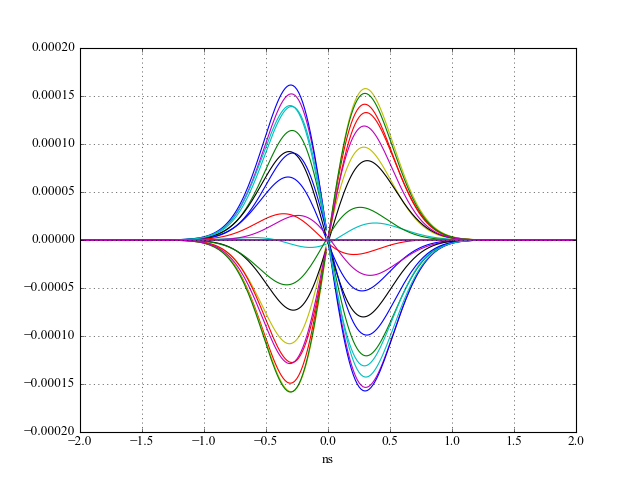

In [11]:
#Second plot shows a serie of signals

plt.figure()

for ii in np.arange(1,20,1):
#     sig_lambda = lambda1tot*np.exp(ii*1j*2*np.pi*(machine.Qxfrac+eigenvalues_converged[Qpindex][EValue_number]/omega0))
#     signal = np.fft.ifft(sig_lambda+np.conj(sig_lambda))
    signal = np.fft.ifft(np.fft.fftshift(lambda1tot))*np.exp(ii*1j*2*np.pi*machine.Qxfrac)

#     signal = signal[0::2]
    
    #freq = np.fft.fftfreq(tau.shape[-1])
    
    n = signal.size

    time = np.fft.fftfreq(n,d=np.diff(omega/2/np.pi)[0]*1e-9)

    plt.plot( time,np.abs(signal)*np.cos(np.angle(signal)), '-')


plt.grid()
plt.show()
plt.xlim(-2,2)
plt.xlabel('ns')